# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [44]:
# import libraries
import numpy as np
import os
import datetime
import os
import keras
from skimage import io
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
from collections import Counter 
import cv2

We set the random seed so that the results don't vary drastically.

In [45]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [46]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

In [47]:
# we started with batch size = 663 and slowly optimised it to fit into our resources 
batch_size = 30 #experiment with the batch size
frames = 30 #number of frames in each video 
# we start with 120*120 images and adjust these later for model building process
rows = 120 # final image height to be decided
cols = 120 # final image width to be decided
channels = 3
step_size = 1 #this will help in customising the frames chosen from the video for model building

In [48]:
# we distribute the images on the basis of size. This is just done for experiment puroposes later.
# outpaths = [train_path] #val_path
def image_segregation(path='train'):
    final_120 =[]
    final_360=[]
    doc = ''
    if(path=='train'):
        op = 'Project_data/train/'
        doc = train_doc
    else:
        op = 'Project_data/val/'
        doc = val_doc
    for f in doc:
        path = f.split(';')[0]
        imgs = os.listdir(op+path)
        for img in imgs:
            image = io.imread(op+path+'/'+img)
            if(image.shape[0]==360):
                final_120.append(op+path+'/'+img) 

            if(image.shape[0]==120):
                final_360.append(op+path+'/'+img)
    return (final_120, final_360)


In [6]:
# make list of images with corresponding sizes
final_120, final_360 = image_segregation()

In [7]:
# view random imagees
selectedIndexes  = []
for i in range(3):
    selectedIndexes.append(rn.randint(0,5520))

s_im_120 = [final_120[i] for i in selectedIndexes]
s_im_360 = [final_360[i] for i in selectedIndexes]
print(s_im_120) # print file name
print(s_im_360)

['Project_data/train/WIN_20180907_15_52_28_Pro_Left Swipe_new_Left Swipe_new/WIN_20180907_15_52_28_Pro_00004.png', 'Project_data/train/WIN_20180907_15_49_14_Pro_Thumbs Down_new/WIN_20180907_15_49_14_Pro_00032.png', 'Project_data/train/WIN_20180907_16_26_02_Pro_Thumbs Up_new/WIN_20180907_16_26_02_Pro_00055.png']
['Project_data/train/WIN_20180926_17_03_21_Pro_Stop_new/WIN_20180926_17_03_21_Pro_00035.png', 'Project_data/train/WIN_20180926_17_22_53_Pro_Thumbs_Up_new/WIN_20180926_17_22_53_Pro_00062.png', 'Project_data/train/WIN_20180925_17_55_57_Pro_Left_Swipe_new/WIN_20180925_17_55_57_Pro_00040.png']


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [49]:
# we have looked at random images from the set and decided the following dimensions for the images. This has helped to 
# remove the edges and preserve the center of the image where gesture data is present. 
def cropImage(image):
    (image_h, image_w, _) = image.shape
    print(image.shape)
    h_start=0
    h_end = image_h
    w_start=0
    w_end = image_w
    # for images 120*160
    if(image_h==120):
        h_start=20
        w_start=10
        w_end = 120
    # for images of size 360*360
    elif image_h==360:
        h_start=30
        w_start=30
        w_end = 320
    return image[h_start:h_end, w_start:w_end]

In [50]:
# this method will adjust the size of the image to given dimensions. The appropriate size will be found through experments.
def resize_image(image, height=rows, width=cols):
    return  resize(image, (height, width),anti_aliasing=False)

In [51]:
# we try different normalization technique
def normalize_image(image):
    norm_image = image - np.min(image)/np.max(image) - np.min(image)
#     norm_image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)
    return norm_image

In [52]:
#utility to show processed images
def showImage(array, idx):
    a = array[idx]
    image = io.imread(a)
    plt.subplot(2, 2,1)
    plt.imshow(image)

    cropped = cropImage(image)
    plt.subplot(2,2,2)
    plt.imshow(cropped)

    resized = resize_image(cropped)
    plt.subplot(2, 2,3)
    plt.imshow(resized)

    
    normalized = normalize_image(resized)
    plt.subplot(2, 2,4)
    plt.imshow(normalized)

    plt.show()

In [12]:
plt.figure(figsize=(300,300))
showImage(s_im_360, 0)

(120, 160, 3)


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [13]:
# view random images
plt.figure(figsize=(300,300))
showImage(s_im_120, 0)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(360, 360, 3)


In [53]:
# Helper function to generate a random affine transform on the iamge
def get_random_affine():
    dx, dy = np.random.randint(-1.7, 1.8, 2)
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    return M

In [54]:
# Helper function to initialize all the batch image data and labels
def init_batch_data(batch_size):
    batch_data = np.zeros((batch_size, frames, rows, cols, channels)) 
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    return batch_data, batch_labels

In [55]:
# internal function to generate augmented data. 
# We have done 2 types of augmentation to prevent overfitting of data- flipping of the images and affine transformation. 
def fetch_aug_batchdata(source_path, folder_list, batch_num, batch_size, t,validation):
    
    batch_data,batch_labels = init_batch_data(batch_size)
    
    # We will also build an augumented batch data with affine transformation
    batch_data_aug,batch_labels_aug = init_batch_data(batch_size)
    
    # We will also build an augmented batch data with horizontal flip
    batch_data_flip,batch_labels_flip = init_batch_data(batch_size)
    
    #create a list of image numbers you want to use for a particular video using full frames
    img_idx = [x for x in range(0, frames)] 

    for folder in range(batch_size): # iterate over the batch_size
        # read all the images in the folder
        imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch_num*batch_size)].split(';')[0])) 
        # Generate a random affine to be used in image transformation for buidling agumented data set
        M = get_random_affine()
        
        #  Iterate over the frames/images of a folder to read them in
        for idx, item in enumerate(img_idx): 
            ## image = imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            image = cv2.imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Cropping non symmetric frames
            if image.shape[0] != image.shape[1]:
                image=image[0:120,20:140]
            
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes   
            resized = cv2.resize(image, (rows, cols), interpolation = cv2.INTER_AREA)
            #Normal data
            batch_data[folder,idx] = (resized)
            
            #Data with affine transformation
            batch_data_aug[folder,idx] = (cv2.warpAffine(resized, M, (resized.shape[0], resized.shape[1])))
            
            # Data with horizontal flip
            batch_data_flip[folder,idx]= np.flip(resized,1)

        batch_labels[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        batch_labels_aug[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        
        # Labeling data with horizobtal flip, right swipe becomes left swipe and viceversa
        if int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==0:
                    batch_labels_flip[folder, 1] = 1
        elif int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==1:
                    batch_labels_flip[folder, 0] = 1
                    
        else:
                    batch_labels_flip[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
                  
    
    batch_data_final = np.append(batch_data, batch_data_aug, axis = 0)
    batch_data_final = np.append(batch_data_final, batch_data_flip, axis = 0)

    batch_labels_final = np.append(batch_labels, batch_labels_aug, axis = 0) 
    batch_labels_final = np.append(batch_labels_final, batch_labels_flip, axis = 0)
    
    if validation:
        batch_data_final=batch_data
        batch_labels_final= batch_labels
        
    return batch_data_final,batch_labels_final

In [56]:
# wrapper generator function. it supports ablation experiment and a flag to decide between training and validation folder
def generator(source_path, folder_list, batch_size, validation=False,ablation=None):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    if(ablation!=None):
        folder_list=folder_list[:ablation]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            # you yield the batch_data and the batch_labels, remember what does yield do

            yield fetch_aug_batchdata(source_path, folder_list, batch, batch_size, t,validation)
        
        # Code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield fetch_aug_batchdata(source_path, folder_list, batch, batch_size, t,validation)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [57]:
# path to images folders
train_path = 'Project_data/train'
val_path = 'Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

classes= 5 # output classes

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [58]:
# function to plot performance of model
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [59]:
# keras related imports
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, ZeroPadding3D
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [60]:
# determine the number of of steps in each epoch for train and validation steps
def getStepsPerEpoch(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    return (steps_per_epoch, validation_steps)

## LSTM Model

### Model 1

In [19]:
# we have decided to experiment with this optimizer first. So keeping it in common place
optimiser = optimizers.Adam(0.001) 

In [23]:
# we will expirment with different number of features for different layers
feature_map=[8, 16, 32, 64, 128] 
dense_layer_size = [1000,500,5]
num_epochs = 10
batch_size = 10
input_shape = (frames, rows, cols, channels)

In [24]:
#write your model here
model = Sequential()
# add multiple convulation layers
model.add(TimeDistributed(Conv2D(feature_map[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))

model.add(TimeDistributed(Conv2D(feature_map[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(feature_map[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(feature_map[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))


model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_layer_size[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense_layer_size[1], activation='relu'))
model.add(Dropout(0.25))

## using LSTM as the RNN model along with softmax as our last layer.
model.add(LSTM(128, return_sequences=False))
model.add(Dense(classes, activation='softmax')) # using Softmax as last layer

In [25]:
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 60, 60, 8)     224       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 15, 15, 64)    8256      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 7, 7, 64)      0         
__________

In [61]:
# timestamp to use in model name. 
curr_dt_time = datetime.datetime.now()

model_name = 'model_init_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [27]:
# initialize the traing and validation generators
train_generator = generator(train_path, train_doc, batch_size,validation=True) # validation=True just prevents the augmentation of data
val_generator = generator(val_path, val_doc, batch_size, validation=True)

In [28]:
# determine the number of of steps in each epoch for train and validation steps
steps_per_epoch, validation_steps = getStepsPerEpoch(num_train_sequences, num_val_sequences, batch_size)

In [29]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                  callbacks=callbacks_list, validation_data=val_generator, 
                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/10
67/67 [==============================] - 110s 2s/step - loss: 1.3169 - categorical_accuracy: 0.4532 - val_loss: 1.1220 - val_categorical_accuracy: 0.5500

Epoch 00001: val_loss improved from inf to 1.12198, saving model to model_init_lstm_2020-11-0819_28_13.859618/model-00001-1.32076-0.45098-1.12198-0.55000.h5
Epoch 2/10
67/67 [==============================] - 38s 562ms/step - loss: 1.2504 - categorical_accuracy: 0.4726 - val_loss: 1.5012 - val_categorical_accuracy: 0.3500

Epoch 00002: val_loss did not improve from 1.12198
Epoch 3/10
67/67 [==============================] - 39s 583ms/step - loss: 1.4830 - categorical_accuracy: 0.3632 - val_loss: 1.4523 - val_categorical_accuracy: 0.3000

Epoch 00003: val_loss did not improve from 1.12198
Epoch 4/10
67/67 [==============================] - 37s 548ms/step - loss: 1.3012 - categorical_accuracy: 0.4726 - val_loss: 1.4130 - val

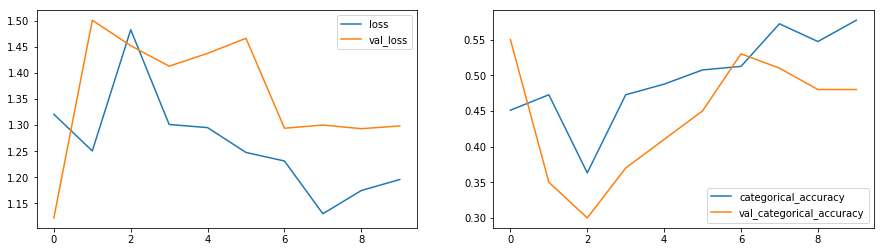

In [30]:
plot(model_history)

#### Validation loss increases and accuracy decreases drastically. The model is overfitting.

### Model 2

#### We augment the data

In [31]:
#write your model here
model = Sequential()
# add multiple convulation layers
model.add(TimeDistributed(Conv2D(feature_map[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))

model.add(TimeDistributed(Conv2D(feature_map[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(feature_map[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(feature_map[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))


model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_layer_size[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense_layer_size[1], activation='relu'))
model.add(Dropout(0.25))

## using LSTM as the RNN model along with softmax as our last layer.
model.add(LSTM(128, return_sequences=False))
model.add(Dense(classes, activation='softmax')) # using Softmax as last layer

In [32]:
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, 30, 60, 60, 8)     224       
_________________________________________________________________
time_distributed_11 (TimeDis (None, 30, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 30, 15, 15, 64)    8256      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 30, 7, 7, 64)      0         
__________

In [33]:
# timestamp to use in model name. 
curr_dt_time = datetime.datetime.now()

model_name = 'model_init_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [34]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size, validation=True)

In [35]:
# calculate steps per eopochs
steps_per_epoch, validation_steps = getStepsPerEpoch(num_train_sequences, num_val_sequences, batch_size)

In [36]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                  callbacks=callbacks_list, validation_data=val_generator, 
                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/10
67/67 [==============================] - 117s 2s/step - loss: 1.6220 - categorical_accuracy: 0.2380 - val_loss: 1.5842 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 1.58417, saving model to model_init_lstm_2020-11-0819_35_46.720144/model-00001-1.62163-0.23932-1.58417-0.21000.h5
Epoch 2/10
67/67 [==============================] - 39s 583ms/step - loss: 1.5558 - categorical_accuracy: 0.2753 - val_loss: 1.5536 - val_categorical_accuracy: 0.2800

Epoch 00002: val_loss improved from 1.58417 to 1.55363, saving model to model_init_lstm_2020-11-0819_35_46.720144/model-00002-1.55576-0.27529-1.55363-0.28000.h5
Epoch 3/10
67/67 [==============================] - 42s 622ms/step - loss: 1.5549 - categorical_accuracy: 0.3167 - val_loss: 1.5349 - val_categorical_accuracy: 0.3100

Epoch 00003: val_loss improved from 1.55363 to 1.53489, saving model to model_

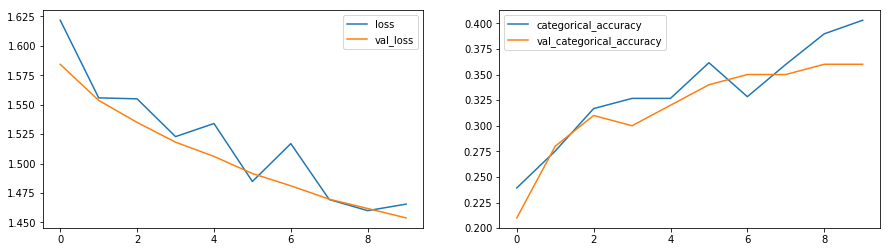

In [37]:
plot(model_history)

### Model 2

#### We add batch normalization

In [38]:
feature_map=[8, 16, 32, 64, 128] # we will expirment with different number of features for different layers
dense_layer_size = [1000,500,5]
num_epochs = 10
batch_size = 10
input_shape = (frames, rows, cols, channels)

In [39]:
#write your model here
model = Sequential()
# add multiple convulation layers
model.add(TimeDistributed(Conv2D(feature_map[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))

model.add(TimeDistributed(Conv2D(feature_map[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))


model.add(TimeDistributed(Conv2D(feature_map[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))


model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_layer_size[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense_layer_size[1], activation='relu'))
model.add(Dropout(0.25))

## using LSTM as the RNN model along with softmax as our last layer.
model.add(LSTM(128, return_sequences=False))
model.add(Dense(classes, activation='softmax')) # using Softmax as last layer

In [40]:
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_19 (TimeDis (None, 30, 60, 60, 8)     224       
_________________________________________________________________
time_distributed_20 (TimeDis (None, 30, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_21 (TimeDis (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 30, 30, 30, 16)    64        
_________________________________________________________________
time_distributed_23 (TimeDis (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_24 (TimeDis (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 30, 15, 15, 32)    128       
__________

In [41]:
# timestamp to use in model name. 
curr_dt_time = datetime.datetime.now()

model_name = 'model_init_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [42]:
# determine the number of of steps in each epoch for train and validation steps
steps_per_epoch, validation_steps = getStepsPerEpoch(num_train_sequences, num_val_sequences, batch_size)

In [43]:
# initalize the generator to reset it for this model
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size, validation=True)

In [44]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                  callbacks=callbacks_list, validation_data=val_generator, 
                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size =Epoch 1/10
 10
67/67 [==============================] - 116s 2s/step - loss: 1.5840 - categorical_accuracy: 0.2647 - val_loss: 1.4499 - val_categorical_accuracy: 0.3900

Epoch 00001: val_loss improved from inf to 1.44988, saving model to model_init_lstm_2020-11-0819_44_03.661838/model-00001-1.58442-0.26395-1.44988-0.39000.h5
Epoch 2/10
67/67 [==============================] - 40s 598ms/step - loss: 1.5297 - categorical_accuracy: 0.3151 - val_loss: 1.4061 - val_categorical_accuracy: 0.4500

Epoch 00002: val_loss improved from 1.44988 to 1.40614, saving model to model_init_lstm_2020-11-0819_44_03.661838/model-00002-1.52966-0.31509-1.40614-0.45000.h5
Epoch 3/10
67/67 [==============================] - 40s 590ms/step - loss: 1.4977 - categorical_accuracy: 0.3383 - val_loss: 1.3782 - val_categorical_accuracy: 0.4900

Epoch 00003: val_loss improved from 1.40614 to 1.37824, saving model to model_

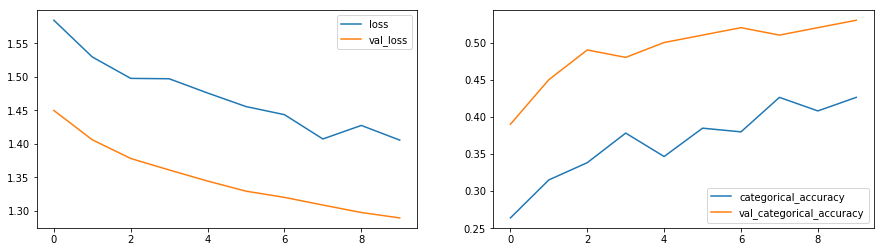

In [45]:
plot(model_history)

### Model 3

#### We reduce the dense layer neurons

In [46]:
feature_map=[8, 16, 32, 64, 128] 
dense_layer_size = [256,128,5] # we reduce the dense layer neurons
num_epochs = 10
batch_size = 10
input_shape = (frames, rows, cols, channels)

In [47]:

model = Sequential()
# add multiple convulation layers
model.add(TimeDistributed(Conv2D(feature_map[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))

model.add(TimeDistributed(Conv2D(feature_map[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

# model.add(keras.layers.Dropout(0.4))

model.add(TimeDistributed(Conv2D(feature_map[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
# model.add(keras.layers.Dropout(0.4))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))


model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_layer_size[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense_layer_size[1], activation='relu'))
model.add(Dropout(0.25))

## using LSTM as the RNN model along with softmax as our last layer.
model.add(LSTM(128, return_sequences=False))
model.add(Dense(classes, activation='softmax')) # using Softmax as last layer

In [48]:
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_30 (TimeDis (None, 30, 60, 60, 8)     224       
_________________________________________________________________
time_distributed_31 (TimeDis (None, 30, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_32 (TimeDis (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 30, 30, 30, 16)    64        
_________________________________________________________________
time_distributed_34 (TimeDis (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_35 (TimeDis (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_36 (TimeDis (None, 30, 15, 15, 32)    128       
__________

In [49]:
# timestamp to use in model name. 
curr_dt_time = datetime.datetime.now()

model_name = 'model_init_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [50]:
# calculate steps per eopochs
steps_per_epoch, validation_steps = getStepsPerEpoch(num_train_sequences, num_val_sequences, batch_size)

In [51]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size, validation=True)

In [52]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                  callbacks=callbacks_list, validation_data=val_generator, 
                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/10
67/67 [==============================] - 115s 2s/step - loss: 1.6152 - categorical_accuracy: 0.2285 - val_loss: 1.5829 - val_categorical_accuracy: 0.3000

Epoch 00001: val_loss improved from inf to 1.58291, saving model to model_init_lstm_2020-11-0819_52_19.262360/model-00001-1.61513-0.22624-1.58291-0.30000.h5
Epoch 2/10
67/67 [==============================] - 39s 586ms/step - loss: 1.5833 - categorical_accuracy: 0.2803 - val_loss: 1.5601 - val_categorical_accuracy: 0.3100

Epoch 00002: val_loss improved from 1.58291 to 1.56013, saving model to model_init_lstm_2020-11-0819_52_19.262360/model-00002-1.58330-0.28027-1.56013-0.31000.h5
Epoch 3/10
67/67 [==============================] - 43s 640ms/step - loss: 1.5670 - categorical_accuracy: 0.2504 - val_loss: 1.5462 - val_categorical_accuracy: 0.3400

Epoch 00003: val_loss improved from 1.56013 to 1.54615, saving model to model_

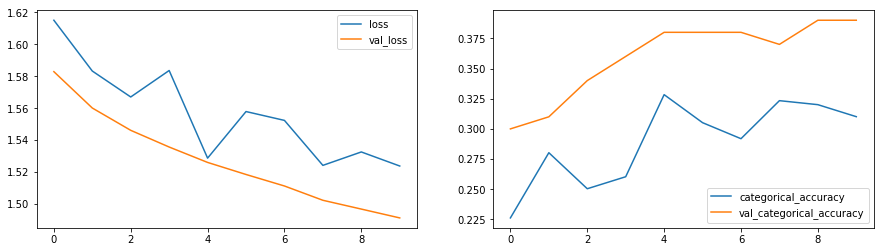

In [53]:
plot(model_history)

### Model 4

#### We increase learning rate

In [54]:
feature_map=[8, 16, 32, 64, 128] 
dense_layer_size = [256,128,5] # we reduce the dense layer neurons
num_epochs = 10
batch_size = 10
input_shape = (frames, rows, cols, channels)

In [55]:

model = Sequential()
# add multiple convulation layers
model.add(TimeDistributed(Conv2D(feature_map[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))

model.add(TimeDistributed(Conv2D(feature_map[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))


model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_layer_size[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense_layer_size[1], activation='relu'))
model.add(Dropout(0.25))

## using LSTM as the RNN model along with softmax as our last layer.
model.add(LSTM(128, return_sequences=False))
model.add(Dense(classes, activation='softmax')) # using Softmax as last layer

In [56]:
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_41 (TimeDis (None, 30, 60, 60, 8)     224       
_________________________________________________________________
time_distributed_42 (TimeDis (None, 30, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_43 (TimeDis (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_44 (TimeDis (None, 30, 30, 30, 16)    64        
_________________________________________________________________
time_distributed_45 (TimeDis (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_46 (TimeDis (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_47 (TimeDis (None, 30, 15, 15, 32)    128       
__________

In [57]:
# timestamp to use in model name. 
curr_dt_time = datetime.datetime.now()

model_name = 'model_init_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [58]:
# calculate steps per eopochs
steps_per_epoch, validation_steps = getStepsPerEpoch(num_train_sequences, num_val_sequences, batch_size)

In [59]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size, validation=True)

In [60]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                  callbacks=callbacks_list, validation_data=val_generator, 
                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/10
67/67 [==============================] - 115s 2s/step - loss: 1.6161 - categorical_accuracy: 0.2204 - val_loss: 1.5667 - val_categorical_accuracy: 0.2900

Epoch 00001: val_loss improved from inf to 1.56674, saving model to model_init_lstm_2020-11-0820_00_31.181404/model-00001-1.61752-0.21921-1.56674-0.29000.h5
Epoch 2/10
67/67 [==============================] - 39s 581ms/step - loss: 1.5980 - categorical_accuracy: 0.2371 - val_loss: 1.5434 - val_categorical_accuracy: 0.3100

Epoch 00002: val_loss improved from 1.56674 to 1.54339, saving model to model_init_lstm_2020-11-0820_00_31.181404/model-00002-1.59795-0.23715-1.54339-0.31000.h5
Epoch 3/10
67/67 [==============================] - 44s 651ms/step - loss: 1.5523 - categorical_accuracy: 0.3134 - val_loss: 1.5247 - val_categorical_accuracy: 0.3200

Epoch 00003: val_loss improved from 1.54339 to 1.52471, saving model to model_

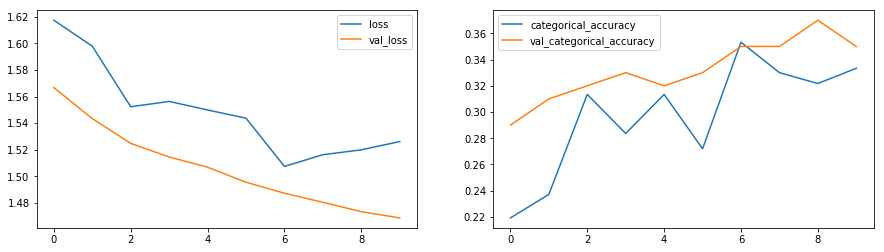

In [61]:
plot(model_history)

## GRU MODEL

In [62]:
#write your model here
feature_map=[8, 16, 32, 64, 128, 256] # we will expirment with different number of features for different layers
dense_layer_size = [1000,500,5] # 
classes= 5
input_shape = (frames, rows, cols, channels)
model = Sequential()
# add multiple convulation layers
model.add(TimeDistributed(Conv2D(feature_map[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))

model.add(TimeDistributed(Conv2D(feature_map[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Conv2D(feature_map[4], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_layer_size[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense_layer_size[1], activation='relu'))
model.add(Dropout(0.25))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(128, return_sequences=False))
model.add(Dense(classes, activation='softmax')) # using Softmax as last layer

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [63]:
# we use adam optimizer
optimiser = optimizers.Adam(0.001) 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_52 (TimeDis (None, 30, 60, 60, 8)     224       
_________________________________________________________________
time_distributed_53 (TimeDis (None, 30, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_54 (TimeDis (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_55 (TimeDis (None, 30, 30, 30, 16)    64        
_________________________________________________________________
time_distributed_56 (TimeDis (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_57 (TimeDis (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_58 (TimeDis (None, 30, 15, 15, 32)    128       
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [64]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size, validation=True)

In [65]:
model_name = 'model_init_CNN' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [66]:
# calculate steps per eopochs
steps_per_epoch, validation_steps = getStepsPerEpoch(num_train_sequences, num_val_sequences, batch_size)

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [67]:
batch_size = 10
num_epochs = 10
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                  callbacks=callbacks_list, validation_data=val_generator, 
                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/10
67/67 [==============================] - 114s 2s/step - loss: 1.1757 - categorical_accuracy: 0.5511 - val_loss: 1.6210 - val_categorical_accuracy: 0.3300

Epoch 00001: val_loss improved from inf to 1.62100, saving model to model_init_CNN_2020-11-0820_00_31.181404/model-00001-1.17693-0.55103-1.62100-0.33000.h5
Epoch 2/10
67/67 [==============================] - 36s 532ms/step - loss: 1.0393 - categorical_accuracy: 0.6036 - val_loss: 1.5706 - val_categorical_accuracy: 0.3700

Epoch 00002: val_loss improved from 1.62100 to 1.57065, saving model to model_init_CNN_2020-11-0820_00_31.181404/model-00002-1.03929-0.60365-1.57065-0.37000.h5
Epoch 3/10
67/67 [==============================] - 40s 599ms/step - loss: 1.0802 - categorical_accuracy: 0.5887 - val_loss: 0.8424 - val_categorical_accuracy: 0.7100

Epoch 00003: val_loss improved from 1.57065 to 0.84238, saving model to model_in

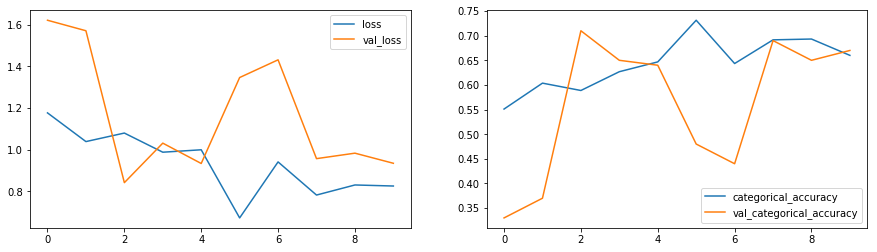

In [68]:
plot(model_history)

### Removing dropout layers

In [69]:
#write your model here
feature_map=[8, 16, 32, 64, 128, 256] # we will expirment with different number of features for different layers
dense_layer_size = [1000,500,5] # 
classes= 5
input_shape = (frames, rows, cols, channels)
model = Sequential()
# add multiple convulation layers
model.add(TimeDistributed(Conv2D(feature_map[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))

model.add(TimeDistributed(Conv2D(feature_map[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[4], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_layer_size[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense_layer_size[1], activation='relu'))
model.add(Dropout(0.25))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(128, return_sequences=False))
model.add(Dense(classes, activation='softmax')) # using Softmax as last layer

In [70]:
# we use adam optimizer
optimiser = optimizers.Adam(0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_66 (TimeDis (None, 30, 60, 60, 8)     224       
_________________________________________________________________
time_distributed_67 (TimeDis (None, 30, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_68 (TimeDis (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_69 (TimeDis (None, 30, 30, 30, 16)    64        
_________________________________________________________________
time_distributed_70 (TimeDis (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_71 (TimeDis (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_72 (TimeDis (None, 30, 15, 15, 32)    128       
__________

In [71]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size, validation=True)

In [72]:
model_name = 'model_init_CNN' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [73]:
# calculate steps per eopochs
steps_per_epoch, validation_steps = getStepsPerEpoch(num_train_sequences, num_val_sequences, batch_size)

In [74]:
batch_size = 10
num_epochs = 20
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                  callbacks=callbacks_list, validation_data=val_generator, 
                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - 117s 2s/step - loss: 1.2081 - categorical_accuracy: 0.4955 - val_loss: 2.1720 - val_categorical_accuracy: 0.2700

Epoch 00001: val_loss improved from inf to 2.17203, saving model to model_init_CNN_2020-11-0820_00_31.181404/model-00001-1.21427-0.49372-2.17203-0.27000.h5
Epoch 2/20
67/67 [==============================] - 38s 561ms/step - loss: 1.1968 - categorical_accuracy: 0.5207 - val_loss: 1.7076 - val_categorical_accuracy: 0.4500

Epoch 00002: val_loss improved from 2.17203 to 1.70756, saving model to model_init_CNN_2020-11-0820_00_31.181404/model-00002-1.19684-0.52073-1.70756-0.45000.h5
Epoch 3/20
67/67 [==============================] - 41s 605ms/step - loss: 1.0758 - categorical_accuracy: 0.6003 - val_loss: 1.0123 - val_categorical_accuracy: 0.6700

Epoch 00003: val_loss improved from 1.70756 to 1.01229, saving model to model_in

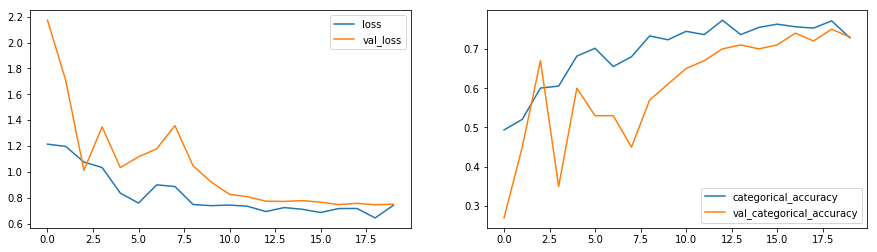

In [75]:
plot(model_history)

### change image size to 84X84

In [20]:
#write your model here
feature_map=[8, 16, 32, 64, 128, 256] # we will expirment with different number of features for different layers
dense_layer_size = [1000,500,5] # 
classes= 5
rows = 84
cols = 84

input_shape = (frames, rows, cols, channels)

model = Sequential()
# add multiple convulation layers
model.add(TimeDistributed(Conv2D(feature_map[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))

model.add(TimeDistributed(Conv2D(feature_map[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Conv2D(feature_map[4], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_layer_size[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense_layer_size[1], activation='relu'))
model.add(Dropout(0.25))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(128, return_sequences=False))
model.add(Dense(classes, activation='softmax')) # using Softmax as last layer

In [21]:
optimiser = optimizers.Adam(0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 42, 42, 8)     224       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 42, 42, 16)    1168      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 21, 21, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 21, 21, 16)    64        
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 21, 21, 32)    4640      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 10, 10, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 10, 10, 32)    128       
__________

In [22]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size, validation=True)

In [23]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init_CNN' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [24]:
# calculate steps per eopochs
steps_per_epoch, validation_steps = getStepsPerEpoch(num_train_sequences, num_val_sequences, batch_size)

In [25]:
batch_size = 10
num_epochs = 20
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                  callbacks=callbacks_list, validation_data=val_generator, 
                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 30
Source path =  Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - 171s 7s/step - loss: 1.3955 - categorical_accuracy: 0.4282 - val_loss: 1.6381 - val_categorical_accuracy: 0.4000

Epoch 00001: val_loss improved from inf to 1.63815, saving model to model_init_CNN_2020-11-0906_05_29.531983/model-00001-1.38100-0.43188-1.63815-0.40000.h5
Epoch 2/20
23/23 [==============================] - 12s 511ms/step - loss: 1.5595 - categorical_accuracy: 0.4300 - val_loss: 1.7464 - val_categorical_accuracy: 0.3750

Epoch 00002: val_loss did not improve from 1.63815
Epoch 3/20
23/23 [==============================] - 15s 637ms/step - loss: 1.4993 - categorical_accuracy: 0.4638 - val_loss: 1.5829 - val_categorical_accuracy: 0.2500

Epoch 00003: val_loss improved from 1.63815 to 1.58294, saving model to model_init_CNN_2020-11-0906_05_29.531983/model-00003-1.49925-0.46377-1.58294-0.25000.h5
Epoch 4/20
23/23 [===========

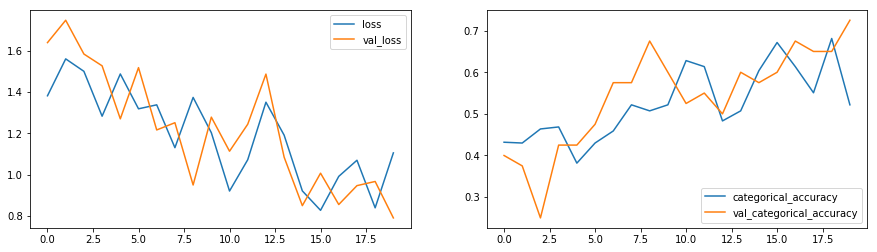

In [26]:
plot(model_history)

### Adding one more dense layer

In [27]:
 # reset image size to 120*120
rows = 120
cols = 120

In [28]:
#write your model here
feature_map=[8, 16, 32, 64, 128, 256] # we will expirment with different number of features for different layers
dense_layer_size = [1000, 500, 250, 5] # 
classes= 5

input_shape = (frames, rows, cols, channels)

model = Sequential()
# add multiple convulation layers
model.add(TimeDistributed(Conv2D(feature_map[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))

model.add(TimeDistributed(Conv2D(feature_map[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Conv2D(feature_map[4], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_layer_size[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense_layer_size[1], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense_layer_size[2], activation='relu'))
model.add(Dropout(0.25))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(128, return_sequences=False))
model.add(Dense(classes, activation='softmax')) # using Softmax as last layer

In [29]:
# we use adam optimizer
optimiser = optimizers.Adam(0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_15 (TimeDis (None, 30, 60, 60, 8)     224       
_________________________________________________________________
time_distributed_16 (TimeDis (None, 30, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 30, 30, 30, 16)    64        
_________________________________________________________________
time_distributed_19 (TimeDis (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 30, 15, 15, 32)    128       
__________

In [30]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size, validation=True)

In [31]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init_CNN' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [32]:
# calculate steps per eopochs
steps_per_epoch, validation_steps = getStepsPerEpoch(num_train_sequences, num_val_sequences, batch_size)

In [33]:
batch_size = 10
num_epochs = 20
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                  callbacks=callbacks_list, validation_data=val_generator, 
                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  Project_data/train ; batch size = 10
 Project_data/valEpoch 1/20
 ; batch size = 10
67/67 [==============================] - 147s 2s/step - loss: 1.2871 - categorical_accuracy: 0.4651 - val_loss: 1.0684 - val_categorical_accuracy: 0.6500

Epoch 00001: val_loss improved from inf to 1.06837, saving model to model_init_CNN_2020-11-0906_13_04.975755/model-00001-1.28730-0.46305-1.06837-0.65000.h5
Epoch 2/20
67/67 [==============================] - 55s 828ms/step - loss: 1.3591 - categorical_accuracy: 0.4710 - val_loss: 2.0404 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss did not improve from 1.06837
Epoch 3/20
67/67 [==============================] - 43s 648ms/step - loss: 1.0761 - categorical_accuracy: 0.5556 - val_loss: 1.1875 - val_categorical_accuracy: 0.6000

Epoch 00003: val_loss did not improve from 1.06837
Epoch 4/20
67/67 [==============================] - 42s 624ms/step - loss: 1.0876 - categorical_accuracy: 0.5987 - val_loss: 1.2033 - val_

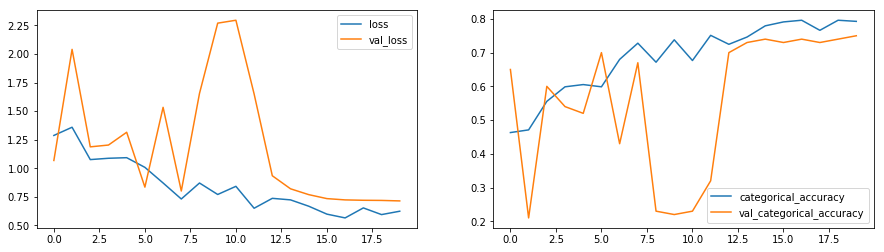

In [34]:
plot(model_history)

## Conv3D model

### Optimiser SGD

In [35]:
filters = [8,16,32,64]
dense = [256, 128, 5]

# Input
input_shape=(frames, rows, cols, channels)

# Define model
model = Sequential()

model.add(Conv3D(filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(dense[0], activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(dense[1], activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(dense[2], activation='softmax'))

In [36]:
# we use adam optimizer
optimiser = optimizers.SGD()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_10 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)    0         
__________

In [37]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size,validation=True)

In [38]:
model_name = 'model_init_Conv3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [39]:
# calculate steps per eopochs
steps_per_epoch, validation_steps = getStepsPerEpoch(num_train_sequences, num_val_sequences, batch_size)

In [40]:
batch_size = 10
num_epochs = 10
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                   callbacks=callbacks_list, validation_data=val_generator, 
                   validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/10
67/67 [==============================] - 120s 2s/step - loss: 1.7406 - categorical_accuracy: 0.2400 - val_loss: 1.5152 - val_categorical_accuracy: 0.3900

Epoch 00001: val_loss improved from inf to 1.51518, saving model to model_init_Conv3D_2020-11-0906_13_04.975755/model-00001-1.74122-0.24133-1.51518-0.39000.h5
Epoch 2/10
67/67 [==============================] - 39s 579ms/step - loss: 1.6275 - categorical_accuracy: 0.2786 - val_loss: 1.5363 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss did not improve from 1.51518
Epoch 3/10
67/67 [==============================] - 42s 623ms/step - loss: 1.5898 - categorical_accuracy: 0.2521 - val_loss: 1.5368 - val_categorical_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 1.51518

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 4/10
67/67 [==============================] - 40s

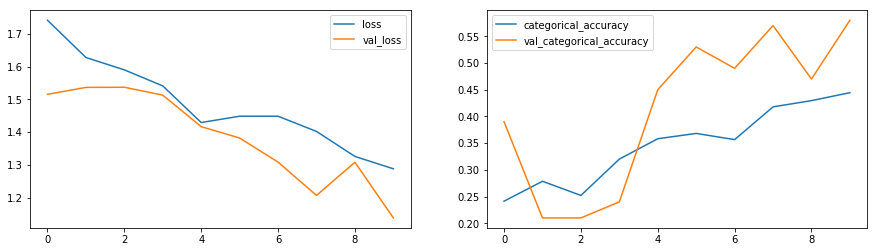

In [41]:
plot(model_history)

### Increased Epochs and Adam optimiser

In [42]:
filters = [8,16,32,64]
dense = [256, 128, 5]

# Input
input_shape=(frames, rows, cols, channels)

# Define model
model = Sequential()

model.add(Conv3D(filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(dense[0], activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(dense[1], activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(dense[2], activation='softmax'))

In [43]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_12 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_5 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_13 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_6 (Activation)    (None, 15, 60, 60, 16)    0         
__________

In [44]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size,validation=True)

In [45]:
model_name = 'model_init_Conv3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [46]:
# calculate steps per eopochs
steps_per_epoch, validation_steps = getStepsPerEpoch(num_train_sequences, num_val_sequences, batch_size)

In [47]:
batch_size = 10
num_epochs = 20
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                   callbacks=callbacks_list, validation_data=val_generator, 
                   validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - 119s 2s/step - loss: 1.7672 - categorical_accuracy: 0.2551 - val_loss: 1.6842 - val_categorical_accuracy: 0.2400

Epoch 00001: val_loss improved from inf to 1.68415, saving model to model_init_Conv3D_2020-11-0906_13_04.975755/model-00001-1.76873-0.25540-1.68415-0.24000.h5
Epoch 2/20
67/67 [==============================] - 40s 594ms/step - loss: 1.4829 - categorical_accuracy: 0.3350 - val_loss: 2.6719 - val_categorical_accuracy: 0.2900

Epoch 00002: val_loss did not improve from 1.68415
Epoch 3/20
67/67 [==============================] - 41s 607ms/step - loss: 1.4294 - categorical_accuracy: 0.3715 - val_loss: 1.3907 - val_categorical_accuracy: 0.3200

Epoch 00003: val_loss improved from 1.68415 to 1.39068, saving model to model_init_Conv3D_2020-11-0906_13_04.975755/model-00003-1.42941-0.37148-1.39068-0.32000.h5
Epoch 4/20
67/67 [=====

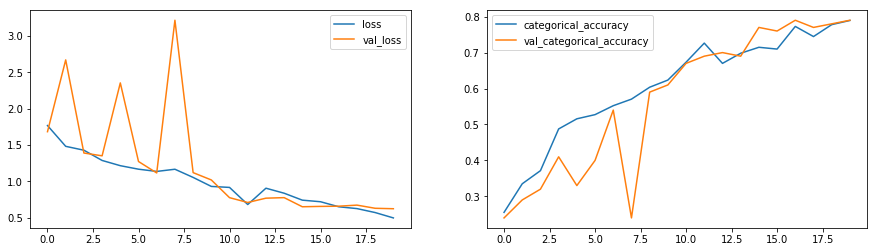

In [48]:
plot(model_history)

### Increasing dense perceptrons

In [49]:
classes= 5
input_shape = (frames, rows, cols, channels)

nb_filters = [8,16,32,64]
nb_dense = [1000, 500, 5]

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [50]:
# we use adam optimizer
optimiser = optimizers.Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_15 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_9 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_16 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_10 (Activation)   (None, 15, 60, 60, 16)    0         
__________

In [51]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size,validation=True)

In [52]:
model_name = 'model_init_Conv3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [53]:
# calculate steps per eopochs
steps_per_epoch, validation_steps = getStepsPerEpoch(num_train_sequences, num_val_sequences, batch_size)

In [54]:
batch_size = 10
num_epochs = 20
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                   callbacks=callbacks_list, validation_data=val_generator, 
                   validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - 118s 2s/step - loss: 2.0573 - categorical_accuracy: 0.2381 - val_loss: 1.5637 - val_categorical_accuracy: 0.2600

Epoch 00001: val_loss improved from inf to 1.56373, saving model to model_init_Conv3D_2020-11-0906_13_04.975755/model-00001-2.06413-0.23831-1.56373-0.26000.h5
Epoch 2/20
67/67 [==============================] - 39s 583ms/step - loss: 1.5910 - categorical_accuracy: 0.3068 - val_loss: 1.7410 - val_categorical_accuracy: 0.1800

Epoch 00002: val_loss did not improve from 1.56373
Epoch 3/20
67/67 [==============================] - 43s 641ms/step - loss: 1.5871 - categorical_accuracy: 0.2587 - val_loss: 1.5914 - val_categorical_accuracy: 0.2700

Epoch 00003: val_loss did not improve from 1.56373

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
67/67 [==============================] - 39

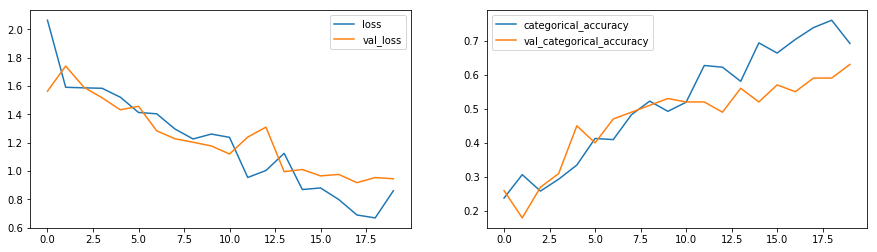

In [55]:
plot(model_history)

### Adding one extra layer with dropout

In [56]:
classes= 5
input_shape = (frames, rows, cols, channels)

nb_filters = [8, 16, 32, 64, 128]
nb_dense = [1000, 500, 5]

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv3D(nb_filters[4], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))


#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [57]:
# we use adam optimizer
optimiser = optimizers.Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_18 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_13 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_19 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_14 (Activation)   (None, 15, 60, 60, 16)    0         
__________

In [58]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size,validation=True)

In [59]:
model_name = 'model_init_Conv3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [60]:
# calculate steps per eopochs
steps_per_epoch, validation_steps = getStepsPerEpoch(num_train_sequences, num_val_sequences, batch_size)

In [61]:
batch_size = 10
num_epochs = 20
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                   callbacks=callbacks_list, validation_data=val_generator, 
                   validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - 119s 2s/step - loss: 1.7820 - categorical_accuracy: 0.2438 - val_loss: 1.5465 - val_categorical_accuracy: 0.2400

Epoch 00001: val_loss improved from inf to 1.54649, saving model to model_init_Conv3D_2020-11-0906_13_04.975755/model-00001-1.78463-0.24635-1.54649-0.24000.h5
Epoch 2/20
67/67 [==============================] - 39s 578ms/step - loss: 1.5769 - categorical_accuracy: 0.2753 - val_loss: 1.5474 - val_categorical_accuracy: 0.3700

Epoch 00002: val_loss did not improve from 1.54649
Epoch 3/20
67/67 [==============================] - 41s 615ms/step - loss: 1.5281 - categorical_accuracy: 0.3317 - val_loss: 1.3024 - val_categorical_accuracy: 0.4400

Epoch 00003: val_loss improved from 1.54649 to 1.30245, saving model to model_init_Conv3D_2020-11-0906_13_04.975755/model-00003-1.52807-0.33167-1.30245-0.44000.h5
Epoch 4/20
67/67 [=====

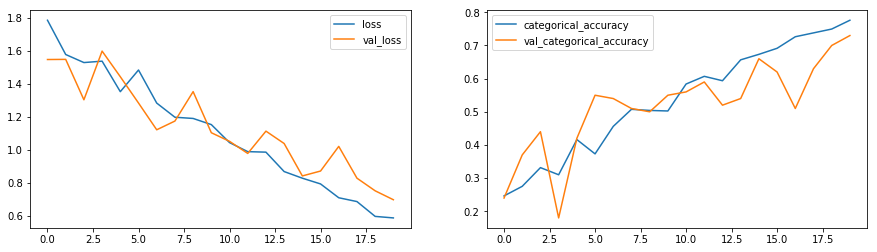

In [62]:
plot(model_history)

### Adding one more layer with BatchNormalization

In [63]:
classes= 5
input_shape = (frames, rows, cols, channels)

nb_filters = [8, 16, 32, 64, 128, 256]
nb_dense = [1000, 500, 5]

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[4], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv3D(nb_filters[5], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))


#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [64]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_18 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_21 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_18 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_22 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_19 (Activation)   (None, 15, 60, 60, 16)    0         
__________

In [65]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size,validation=True)

In [66]:
model_name = 'model_init_Conv3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [67]:
# calculate steps per eopochs
steps_per_epoch, validation_steps = getStepsPerEpoch(num_train_sequences, num_val_sequences, batch_size)

In [68]:
batch_size = 10
num_epochs = 20
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                   callbacks=callbacks_list, validation_data=val_generator, 
                   validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Epoch 1/20Project_data/train ; batch size = 10

67/67 [==============================] - 121s 2s/step - loss: 2.1297 - categorical_accuracy: 0.2476 - val_loss: 1.5016 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 1.50155, saving model to model_init_Conv3D_2020-11-0906_13_04.975755/model-00001-2.13574-0.24786-1.50155-0.23000.h5
Epoch 2/20
67/67 [==============================] - 37s 548ms/step - loss: 1.5457 - categorical_accuracy: 0.3167 - val_loss: 1.5983 - val_categorical_accuracy: 0.2200

Epoch 00002: val_loss did not improve from 1.50155
Epoch 3/20
67/67 [==============================] - 42s 630ms/step - loss: 1.5508 - categorical_accuracy: 0.2803 - val_loss: 1.6371 - val_categorical_accuracy: 0.1700

Epoch 00003: val_loss did not improve from 1.50155

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
67/67 [==============================] - 41

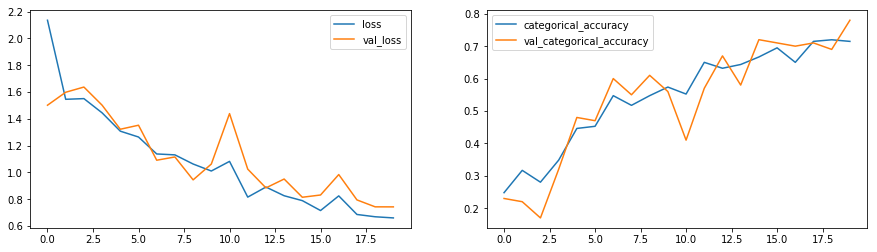

In [69]:
plot(model_history)

### Reduce the filter size

In [23]:
classes= 5
input_shape = (frames, rows, cols, channels)

nb_filters = [8, 16, 32, 64, 128, 256]
nb_dense = [1000, 500, 5]

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(2,2,2), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(2,2,2), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[4], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv3D(nb_filters[5], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))


#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [24]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   200       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    1040      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)    0         
__________

In [25]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size,validation=True)

In [26]:
model_name = 'model_init_Conv3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [27]:
# calculate steps per eopochs
steps_per_epoch, validation_steps = getStepsPerEpoch(num_train_sequences, num_val_sequences, batch_size)

In [28]:
batch_size = 10
num_epochs = 20
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                   callbacks=callbacks_list, validation_data=val_generator, 
                   validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  Project_data/train ; batch size = 30
 Project_data/val Epoch 1/20
; batch size = 30
23/23 [==============================] - 178s 8s/step - loss: 3.5504 - categorical_accuracy: 0.2181 - val_loss: 1.5716 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 1.57155, saving model to model_init_Conv3D_2020-11-0909_23_22.771809/model-00001-3.62348-0.22222-1.57155-0.23000.h5
Epoch 2/20
23/23 [==============================] - 13s 571ms/step - loss: 1.6101 - categorical_accuracy: 0.1498 - val_loss: 1.5887 - val_categorical_accuracy: 0.3250

Epoch 00002: val_loss did not improve from 1.57155
Epoch 3/20
23/23 [==============================] - 20s 883ms/step - loss: 1.5797 - categorical_accuracy: 0.2899 - val_loss: 1.5841 - val_categorical_accuracy: 0.3750

Epoch 00003: val_loss did not improve from 1.57155

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
23/23 [==============================] - 19

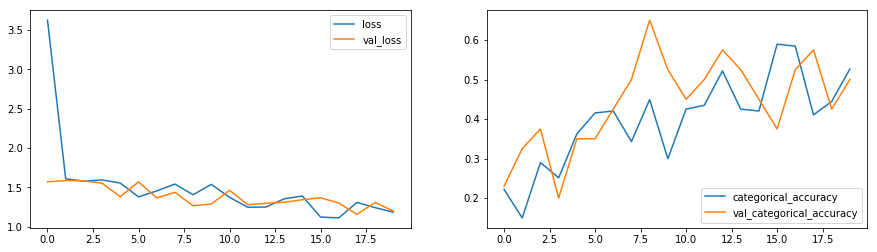

In [29]:
plot(model_history)

## Transfer learning

In [62]:
from keras.applications import mobilenet

In [31]:
num_epochs = 20
batch_size = 10
input_shape = (frames, rows, cols, channels)

In [32]:
# we use the mobilenet model without training the previous convolutional layers
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(frames, rows, cols, channels)))
        
        
for layer in model.layers:
    layer.trainable = False
        
        
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(128))
model.add(Dropout(0.25))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(classes, activation='softmax'))  

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 5s 0us/step


In [33]:
# Adam optimizer
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
__________

In [34]:
# reset the generator
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [35]:
# calculate steps per eopochs
steps_per_epoch, validation_steps = getStepsPerEpoch(num_train_sequences, num_val_sequences, batch_size)

In [36]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                   callbacks=callbacks_list, validation_data=val_generator, 
                   validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - 130s 2s/step - loss: 1.2932 - categorical_accuracy: 0.4569 - val_loss: 1.9739 - val_categorical_accuracy: 0.2167

Epoch 00001: val_loss did not improve from 1.15756
Epoch 2/20
67/67 [==============================] - 47s 702ms/step - loss: 1.2381 - categorical_accuracy: 0.5025 - val_loss: 1.7712 - val_categorical_accuracy: 0.2233

Epoch 00002: val_loss did not improve from 1.15756
Epoch 3/20
67/67 [==============================] - 45s 676ms/step - loss: 1.0534 - categorical_accuracy: 0.5572 - val_loss: 1.6720 - val_categorical_accuracy: 0.2433

Epoch 00003: val_loss did not improve from 1.15756
Epoch 4/20
67/67 [==============================] - 45s 672ms/step - loss: 1.0205 - categorical_accuracy: 0.6070 - val_loss: 1.7563 - val_categorical_accuracy: 0.2300

Epoch 00004: val_loss did not improve from 1.15756
Epoch 5/20
67/67 [======

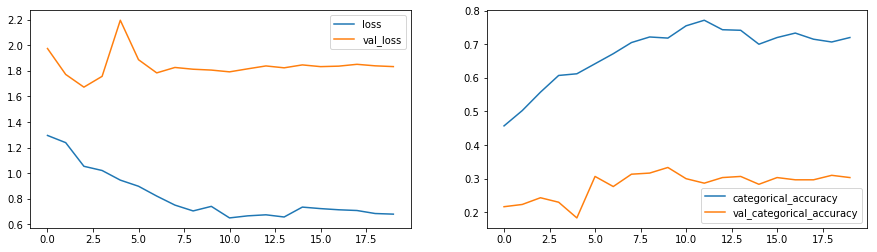

In [37]:
plot(model_history)

### Trainable layers

In [63]:
num_epochs = 20
batch_size = 5
frames = 16
input_shape = (frames, rows, cols, channels)

In [64]:
# We re-train the layers of mobilenet model. 
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(frames, rows, cols, channels)))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(128))
model.add(Dropout(0.25))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(classes, activation='softmax'))  

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [65]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_18 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
__________

In [66]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [67]:
# calculate steps per eopochs
steps_per_epoch, validation_steps = getStepsPerEpoch(num_train_sequences, num_val_sequences, batch_size)

In [68]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                   callbacks=callbacks_list, validation_data=val_generator, 
                   validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/valSource path =  Project_data/train ; batch size = 5
Epoch 1/20 ; batch size = 5

133/133 [==============================] - 143s 1s/step - loss: 1.1923 - categorical_accuracy: 0.5078 - val_loss: 1.2723 - val_categorical_accuracy: 0.4667

Epoch 00001: val_loss improved from inf to 1.27230, saving model to model_init_lstm_2020-11-0910_18_57.089147/model-00001-1.19383-0.50729-1.27230-0.46667.h5
Epoch 2/20
133/133 [==============================] - 79s 590ms/step - loss: 0.9903 - categorical_accuracy: 0.6433 - val_loss: 1.1029 - val_categorical_accuracy: 0.5967

Epoch 00002: val_loss improved from 1.27230 to 1.10295, saving model to model_init_lstm_2020-11-0910_18_57.089147/model-00002-0.99031-0.64327-1.10295-0.59667.h5
Epoch 3/20
133/133 [==============================] - 79s 593ms/step - loss: 0.9328 - categorical_accuracy: 0.6725 - val_loss: 1.0486 - val_categorical_accuracy: 0.6233

Epoch 00003: val_loss improved from 1.10295 to 1.04859, saving model to mo

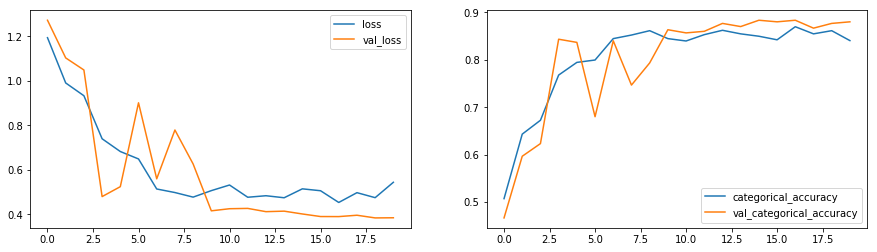

In [69]:
plot(model_history)